In [1]:
from coppelia_youbot import *
import matplotlib.pyplot as plt
from skspatial.objects import Plane


Sim.sim.startSimulation()
sleep(0.1)
robot = assemble_robot()
robot.platform.stop()
camera = VisionSensor('/Vision_sensor', PI/3, (16, 16), 0.01, 10.)
matrix, depth, image = camera.shoot(True)
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(depth)

AssertionError: 

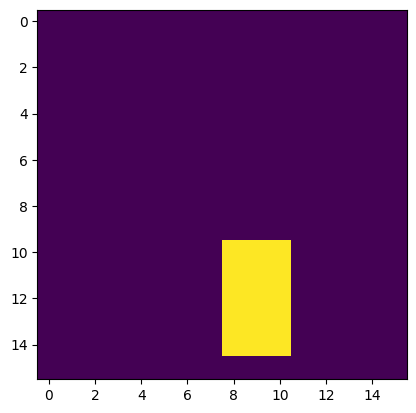

In [91]:
RED = np.array([255, 0, 0])
mask = np.linalg.norm(image - RED, axis=2) < 150
plt.imshow(mask)

Text(0.5, 0, 'z')

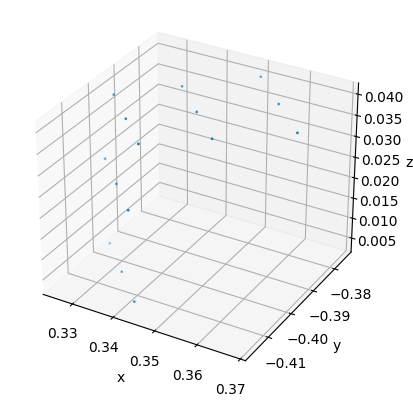

In [92]:
cloud = camera.get_cloud(depth, matrix, (0, 0), depth.shape)[:, mask.flatten()]
ax = plt.subplot(projection='3d')
ax.scatter(*cloud, s=1)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z') # type: ignore

In [93]:
center = (cloud.max(axis=1) + cloud.min(axis=1))/2
true_center = np.array(SimObject('/Rectangle13').get_pos())
labels = ('Истина', 'Расчёт', 'Дельта')
for title, data in zip(labels, (true_center, center, center-true_center)):
    print(f'{title}:\t{data[0]:.3f}\t{data[1]:.3f}\t{data[2]:.3f}')

Истина:	0.347	-0.401	0.020
Расчёт:	0.347	-0.396	0.022
Дельта:	0.000	0.005	0.002


Text(0.5, 0, 'z')

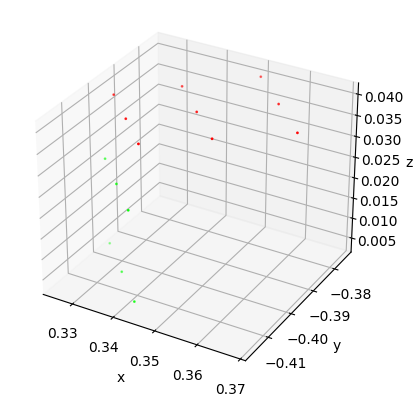

In [94]:
def iteration3D(cloud: np.ndarray, precision: float = 0.001) -> tuple[int, Plane | None]:
    if cloud.shape[1] <= 2:
        return 0, None
    seed = cloud[:, np.random.randint(0, cloud.shape[1]-1, size=3)].transpose()
    try:
        plane = Plane.from_points(*seed)
    except ValueError:
        return 0, None
    d = plane.distance_points(cloud.transpose())
    return np.count_nonzero(d <= precision), plane


def ransac(cloud: np.ndarray, n_planes: int = 3, precision: float = 0.001, iterations: int = 100) -> list[Plane]:
    planes: list[Plane] = []
    step_cloud = cloud.copy()
    for _ in range(n_planes):
        d = dict(iteration3D(step_cloud, precision) for _ in range(iterations))
        if 0 in d: d.pop(0) 
        if len(d) < 1:
            continue
        planes.append(d[max(d)]) # type: ignore
        step_cloud = step_cloud[:, ~(planes[-1].distance_points(step_cloud.transpose()) < precision)]
    return planes


planes = ransac(cloud)
colors = np.array([plane.distance_points(cloud.transpose()) < 0.001 for plane in planes]).astype(np.uint8) # type: ignore
if colors.shape[0] == 2:
    colors = np.vstack((colors, np.zeros_like(colors[0])))
ax = plt.subplot(projection='3d')
ax.scatter(*cloud, s=1, c=colors.transpose())
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z') # type: ignore

In [95]:
normales = np.array([plane.normal for plane in planes])
vector = normales[np.argmin(np.abs(normales[:, 2]))]
orientation = np.arctan2(vector[1], vector[0]) % (PI/2)

true_orientation = np.array(SimObject('/Rectangle13').get_orient()[2] % (PI/2))

for title, data in zip(labels, (true_orientation, orientation, orientation-true_orientation)):
    print(f'{title}:\t{data:.3f}')

Истина:	0.771
Расчёт:	0.770
Дельта:	-0.000


In [96]:
robot.arm.take(tuple(center), Angle(orientation))
robot.arm.park()
Sim.sim.stopSimulation()

KeyboardInterrupt: 